# Tour of ProblY

The core of ProblY is the class `rvar` class. There are two main ways to instantiate objects of this class: directly from some sampling mechanism, as new independent random variables; or in terms of other, already existing `rvar` objects. In order to produce random samples, the first kinds of `rvar` objects are necessary. However, the emphasis on ProblY is on building up the second kind of objects and their dependence relations. We provide examples below. We will need to import the following modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.stats as stats

from probly import rvar, Lift

## 1 Building blocks: direct instantiation

### 1.1 Custom sampler

The most direct way to construct a `rvar` object is via a sampling method that takes a parameter `seed` as input and outputs a random numeric type (`int`, `float`, `numpy.ndarray`, etc.). If `seed` is set to `None`, a random seed will be generated internally.

In [2]:
# Example: a not very random sampler
def sampler(seed=None):
    return seed

X = rvar.define(sampler)
X()

611240401

A seed can be passed to an `rvar` object as follows.

In [3]:
x = X(10)
x

817864850

Note that the input seed `10` was not used as the actual seed. Nevertheless, seeding allows the production of reproducible results.

In [4]:
x - X(10)

0

The reason for this has to do with the implementation of independence, discussed further below.

### 1.2 Wrappers for other packages

Implementations of probability distributions from the `random`, `numpy`, and `scipy.stats` modules can easily be wrapped in a ProblY `rvar` object.

In [5]:
X1 = rvar.define(random.random, 'random')
X2 = rvar.define(np.random.rand, 'numpy')
X3 = rvar.define(stats.uniform, 'scipy')
X4 = rvar.define(stats.uniform(), 'scipy')

In [6]:
print(X1(11))
print(X2(11))
print(X3(11))
print(X4(11))

0.23179155158606235
0.34046230086345475
0.563351461052
0.795353277607


### 1.3 Independent copies

Independent copies of a random variable are easily produced as follows.

In [7]:
Y1 = rvar.copy(X1)

In [8]:
print(Y1(0) - X1(0))
print(Y1(1) - X1(1))

0.5354723208748787
0.5776650199434146


## 2 Constructing more complex random variables

The goal of ProblY is not so much to define and catalogue a wide variety of different statistical distribution: such distributions are already available in a number of other excellent packages. As in the examples above, one can use such packages to define a number of simple random variables that can then be manipulated and transformed using ProblY.

The following kinds of random variable transformations are built into ProblY: arithmetical operations (`+`, `-`, `*`, `/`, `//`, `%`, etc.), array formation, and indexing. However, any operation on numbers or arrays can be applied to random variables.

### 2.1 Random variable arithmetic

In [9]:
Z1 = X1 + Y1
Z2 = X2 * X3
Z3 = X4 / (X1 + X2)

In [10]:
print(Z1(0))
print(Z2(0))
print(Z3(0))

1.0917242835241798
0.370001644099
0.870770293304


An important feature of the implementation of these operations in ProblY is the maintenance of **dependence structures**, by which consistent results can be achieved. This is demonstrated below.

In [11]:
print('{:.2f} + {:.2f} = {:.2f}'.format(X1(5), Y1(5), Z1(5)))

0.56 + 0.25 = 0.81


Here is another example. The point is that random variables are always dependent on other random variables from which they were defined.

In [12]:
Y = 100 + X1
Z = Y - X1
Z()

100.0

### 2.2 Array formation and indexing

Random variables can easily be grouped into arrays using the `rvar.array` class method and random arrays can be indexed and spliced into other random arrays or variables.

In [13]:
Z = rvar.array([[Z1, Z2], [Z3, Z3]])

In [14]:
print(Z(19))
print(Z[0](19))
print(Z[0, 1](19))

[[ 0.48360591  0.16200407]
 [ 0.36220142  0.36220142]]
[ 0.48360591  0.16200407]
0.162004067698


### 2.3 Custom operations

Any function `f` on numerical data types can be *lifted* to a map of random variables using `Lift` method.

In [15]:
def f(x):
    return x ** 2 - 2 * x + 1
f = Lift(f)
W = f(Z1)
W(19)

0.2666628561360467

A lifted map can also be defined directly using the `Lift` decoration.

In [16]:
@Lift
def g(x, y):
    return x[0] + y ** 2

W = g(Z[1], Z2)

In [17]:
W(19)

0.38844674107065402

## 3 More examples

### 3.1 Trace of a random matrix

In [18]:
Trace = Lift(np.trace)
T = Trace(Z)

In [19]:
print(T(0))

1.96249457683


### 3.2 Leading eigenvalue of a random Wishart matrix

We can use the `scipy.stats.wishart` implementation of random Wishart matrices to sample their leading eigenvalues and construct a histogram.

In [20]:
@Lift
def largest_eig(matrix):
    return np.max(np.linalg.eig(matrix)[0])

W = rvar.define(stats.wishart(scale=np.eye(2)), 'scipy')
Lambda = largest_eig(W)

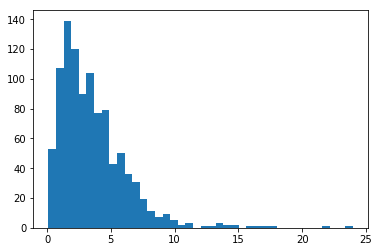

In [21]:
samples = [Lambda(i) for i in range(1000)]
_ = plt.hist(samples, bins=40)